<center>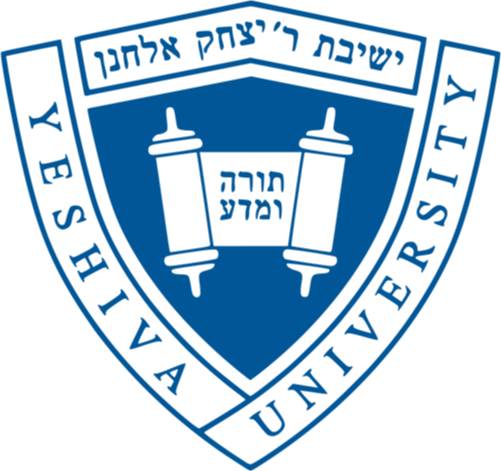</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5007 Neural Networks and Deep Learning</h1>
<p>
<h2 style='text-align: center;'>Project 1</h1>
<br><br>

<h3 style='text-align: center;'>Radek Jan Holik</h3>
<br>
<br>

# Package import

In [1]:
# Import some important packages here
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import cv2 as cv
import os
from datetime import datetime  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import  Dataset, DataLoader, random_split
import torch.nn.functional as F
from collections import Counter

from PIL import Image
from torchsummary import summary


import warnings
warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)

generator = torch.Generator()
generator.manual_seed(0)

In [2]:
if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : NVIDIA GeForce RTX 3090


# 1. Build your own convolutional neural network using pytorch

In [3]:
# Define the neural network architecture
class my_CCN(nn.Module):
    def __init__(self, num_classes):
        super(my_CCN, self).__init__()

        # Feature Learning / Convolutional Layers:

        # 1st Convolutional Layer
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 7, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
         )
        
        # 2nd Convolutional Layer
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64)
         )
        
        # 3rd Convolutional Layer
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        # # 4th Convolutional Layer
        # self.block4 = nn.Sequential(
        #     nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        #     nn.LeakyReLU(inplace = True),
        #     nn.BatchNorm2d(256)
        # )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 3844, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.block4(x)

        x = torch.flatten(x, 1) # Flatten input tensor 

        x = self.fc(x)
        return x

In [4]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()

        # Branch 1x1 (identity connection)
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
        )
        # Branch 3x3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
        )
        # Branch 5x5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
        )
        # Max pool
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1),
            nn.BatchNorm2d(out_channels // 4),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)


        return torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], dim=1)#torch.cat([x1, x3, x5, pool_branch], dim=1)
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Add a 1x1 convolution layer to adjust the dimensionality of the identity connection
        self.identity_conv = None
        if in_channels != out_channels:
            self.identity_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x

        out = F.leaky_relu(self.conv1(x))
        out = self.conv2(out)
        out = self.batch_norm(out)

        # Adjust the dimensionality of the identity connection if needed
        if self.identity_conv is not None:
            identity = self.identity_conv(identity)

        return F.leaky_relu(out + identity)
    
class RodysNet(nn.Module):
    def __init__(self, num_classes=4):
        super(RodysNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inception1 = InceptionBlock(32, 96)
        self.transition1 = nn.Conv2d(96, 80, kernel_size=1)  # Added 1x1 convolution
        self.residual1 = ResidualBlock(80, 80)

        self.inception2 = InceptionBlock(80, 160)
        self.transition2 = nn.Conv2d(160, 160, kernel_size=1)  # Added 1x1 convolution
        self.residual2 = ResidualBlock(160, 160)

        self.inception3 = InceptionBlock(160, 320)
        self.transition3 = nn.Conv2d(320, 320, kernel_size=1)  # Added 1x1 convolution
        self.residual3 = ResidualBlock(320, 320)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(320 * 16 * 16, 512),
            # nn.Linear(320 * 1024 * 16, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))

        x = self.inception1(x)
        x = self.transition1(x)
        x = self.pool(self.residual1(x))
        # x = self.residual1(x)
        

        x = self.inception2(x)
        x = self.transition2(x)
        x = self.pool(self.residual2(x))
        # x = self.residual2(x)

        x = self.inception3(x)
        x = self.transition3(x)
        x = self.pool(self.residual3(x))
        # x = self.residual3(x)

        x = torch.flatten(x, 1) # Flatten input tensor 

        x = self.fc(x)

        return x



In [5]:
# Hyper-parameters
num_classes = 4
num_epochs = 300
batch_size = 128
image_size = (256, 256)

learning_rate = 1e-4
l1_lambda = 1e-5

In [6]:
# Initialize the model
model = RodysNet(num_classes).to(device)
# model = my_CCN(num_classes).to(device)

print(model)

RodysNet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception1): InceptionBlock(
    (branch1): Sequential(
      (0): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (branch2): Sequential(
      (0): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (branch3): Sequential(
      (0): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentu

In [7]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 24, 128, 128]             792
       BatchNorm2d-4         [-1, 24, 128, 128]              48
         LeakyReLU-5         [-1, 24, 128, 128]               0
            Conv2d-6         [-1, 24, 128, 128]             792
       BatchNorm2d-7         [-1, 24, 128, 128]              48
         LeakyReLU-8         [-1, 24, 128, 128]               0
            Conv2d-9         [-1, 24, 128, 128]           5,208
      BatchNorm2d-10         [-1, 24, 128, 128]              48
        LeakyReLU-11         [-1, 24, 128, 128]               0
           Conv2d-12         [-1, 24, 128, 128]             792
      BatchNorm2d-13         [-1, 24, 128, 128]              48
        LeakyReLU-14         [-1, 24, 1

In [8]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

44,933,396 model parameters


In [9]:
print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 171.463MB


In [10]:
def test_model(model, image_size):
    x = torch.randn(2, 3, image_size[0], image_size[1]).to(device) # 2 random pictrures
    y = model(x).to(device)
    
    print(y.argmax(dim = 1, keepdim = True))

test_model(model, image_size)

tensor([[1],
        [1]], device='cuda:0')


# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### __(1) Use torchvision.datasets.ImageFolder for the training dataset__

In [11]:
# Set up the data loaders
def get_data_loaders(path, shuffle = True, batch_size = 256, image_size = (256, 256), normilize = False, mean = [0.4190, 0.3147, 0.3084], std = [0.4238, 0.4043, 0.4237]):

    # Define the transformations to be applied to the images
    if normilize:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),  # convert the images to PyTorch tensors
            transforms.Normalize(mean = mean, std = std)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()  # convert the images to PyTorch tensors
        ])

    # Load the dataset
    dataset = datasets.ImageFolder(path, transform = transform)

    # Define the sizes of the training and validation sets
    train_size = int(0.90 * dataset.__len__())
    val_size = len(dataset) - train_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, lengths = [train_size, val_size], generator = generator)

    # Create data loaders for the training and validation datasets
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = shuffle)
    val_loader = DataLoader(val_dataset, batch_size = val_dataset.__len__(), shuffle = shuffle)

    
    return train_loader, val_loader

In [12]:
# Define dataset directory
data_dir = './data/dataset'

In [13]:
# Define dataset directory and batch size
data_test = './data/test'

In [14]:
train_dataloader, val_dataloader = get_data_loaders(data_dir, shuffle = True, batch_size = batch_size, image_size = (int(image_size[0] * 1.2), int(image_size[0] * 1.2)))

#### __Training data__

In [15]:
# Return a dictionary with the count of labels for each class
def count_labels(data_loader):
    class_counts = {}

    for images, labels in data_loader:
        unique_labels, counts = torch.unique(labels, return_counts = True)
        for label, count in zip(unique_labels.tolist(), counts.tolist()):
            if label in class_counts:
                class_counts[label] += count
            else:
                class_counts[label] = count

    return class_counts

In [16]:
# Distribution of training data into individual classes
train_label_counts = count_labels(train_dataloader)
print(train_label_counts)

{0: 413, 1: 431, 2: 170, 3: 20}


In [17]:
# Check it's working
number_pic = 0
for batch, (X, y) in enumerate(train_dataloader):
    number_pic += X.shape[0]

    if batch + 1 == 1:
        print(f"Batch: {batch+1}")
        print(f"X.shape: {X.shape}")
        print(f"y.shape: {y.shape}")
        print()
print(f"Number of training images: {number_pic}")

Batch: 1
X.shape: torch.Size([128, 3, 307, 307])
y.shape: torch.Size([128])

Number of training images: 1034


#### __Validation data__

In [18]:
# Distribution of validation data into individual classes
val_label_counts = count_labels(val_dataloader)
print(val_label_counts)

{0: 37, 1: 60, 2: 17, 3: 1}


In [19]:
# Check it's working
number_pic = 0
for batch, (X, y) in enumerate(val_dataloader):
    number_pic += X.shape[0]

    if batch + 1 == 1:
        print(f"Batch: {batch+1}")
        print(f"X.shape: {X.shape}")
        print(f"y.shape: {y.shape}")
        print()
        
print(f"Number of validation images: {number_pic}")

Batch: 1
X.shape: torch.Size([115, 3, 307, 307])
y.shape: torch.Size([115])

Number of validation images: 115


### __Plot of random testing samples__

In [20]:
train_examples = next(iter(train_dataloader))

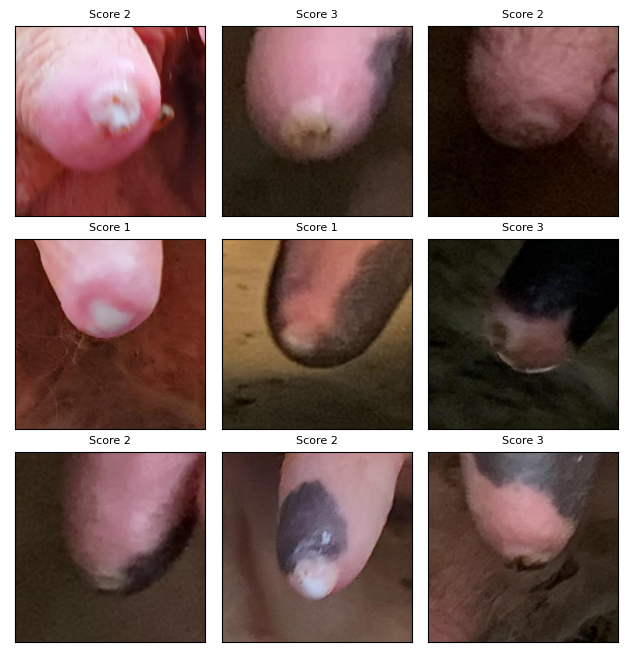

In [21]:
plt.figure(figsize = (8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_examples[0][i].permute(1, 2, 0))
    plt.title(f'Score {train_examples[1][i].item() + 1}', fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace = 0, hspace = 0.12)

### __Plot of random validation samples__

In [22]:
val_examples = next(iter(val_dataloader))

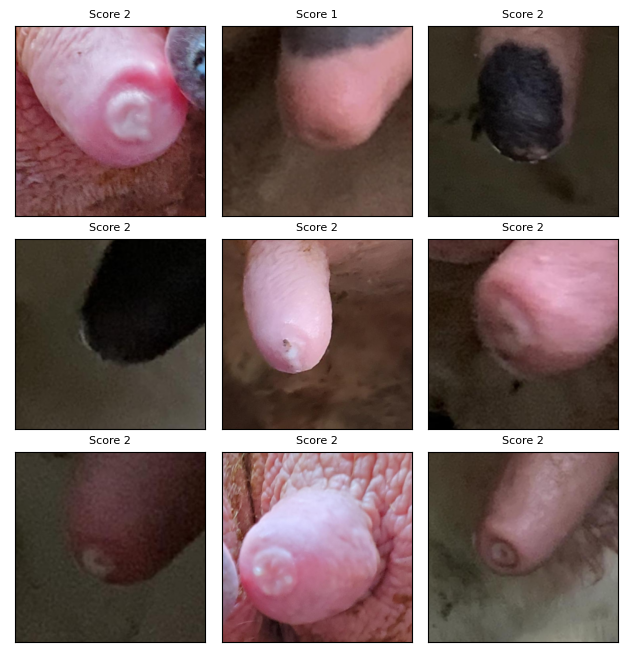

In [23]:
plt.figure(figsize = (8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(val_examples[0][i].permute(1, 2, 0))
    plt.title(f'Score {val_examples[1][i].item() + 1}', fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace = 0, hspace = 0.12)

### __Mean and std of the training data set__

In [24]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim = [0, 2, 3])
        sum_of_square = torch.sum(images**2, dim = [0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment**2)        
    return mean, std

In [25]:
train_mean, train_std = batch_mean_and_sd(train_dataloader)
print(f"train_mean : {train_mean}")
print(f"train_std : {train_std}")

train_mean : tensor([0.4180, 0.3124, 0.3027])
train_std : tensor([0.2389, 0.2051, 0.2393])


### __Data Augmentation__

In [26]:
# Augment training data
class TestSet(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = os.listdir(img_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path) 
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
transform = transforms.Compose([
                        transforms.Resize((int(image_size[0] * 1.2), int(image_size[0] * 1.2))),
                        transforms.RandomRotation((-23,23)),
                        transforms.RandomCrop(image_size),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=train_mean, std=train_std)
                        ])

In [28]:
test_transform = transforms.Compose([
                        transforms.Resize((int(image_size[0] * 1.2), int(image_size[0] * 1.2))),
                        transforms.RandomCrop(image_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=train_mean, std=train_std)
                        ])

In [29]:
# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform = transform)

# Define the sizes of the training and validation sets
train_size = int(0.90 * dataset.__len__())
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, lengths = [train_size, val_size], generator = generator)

# Create data loaders for the training and validation datasets
train_dataloader= DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

test_dataset = TestSet(img_dir = data_test, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [30]:
# Check it's working
number_pic = 0
for batch, (X, y) in enumerate(train_dataloader):
    number_pic += X.shape[0]

    if batch + 1 == 1:
        print(f"Batch: {batch+1}")
        print(f"X.shape: {X.shape}")
        print(f"y.shape: {y.shape}")
        print()
print(f"Number of training images: {number_pic}")

Batch: 1
X.shape: torch.Size([128, 3, 256, 256])
y.shape: torch.Size([128])

Number of training images: 1034


In [31]:
# Check it's working
number_pic = 0
for batch, (X, y) in enumerate(val_dataloader):
    number_pic += X.shape[0]

    if batch + 1 == 1:
        print(f"Batch: {batch+1}")
        print(f"X.shape: {X.shape}")
        print(f"y.shape: {y.shape}")
        print()
        
print(f"Number of validation images: {number_pic}")

Batch: 1
X.shape: torch.Size([115, 3, 256, 256])
y.shape: torch.Size([115])

Number of validation images: 115


### __Training part__

In [32]:
def save_model():

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a csv folder
    saved_models_folder = "./saved_models"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # Export (save) of the model:
    # torch.save(model, "./saved_models/")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_name = model.__class__.__name__
    model_scripted.save('./saved_models/' +  model_name + '_' + year_time + '.pt') # Save

In [33]:
def saveList(myList, filename):

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a csv folder
    saved_models_folder = "./my_lists"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # the filename should mention the extension 'npy'
    path = saved_models_folder + '/'+  str(filename) + '_' + year_time + '.npy'

    np.save(path, myList)
    # print("Saved successfully!")

In [34]:
# Pre-training preparation

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [35]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()#weight = class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l1_lambda)

loss_values_train = []
loss_values_val = []
accuracy_train = []
accuracy_val = []

In [36]:
# num_epochs = 100
# learning_rate = 1e-4
# l1_lambda = 1e-5
print(f"learning_rate = {learning_rate}")
print(f"l1_lambda = {l1_lambda}")
print(f"num_epochs = {num_epochs}")

learning_rate = 0.0001
l1_lambda = 1e-05
num_epochs = 300


In [37]:
# Train the model
for epoch in range(num_epochs):

    ########################## TRAINING ###############################
    # Set the network to training mode
    model.train()

    train_correct = 0
    train_total = 0
    train_loss = 0

    # Iterate over the batches of training data
    for i, (x_train, y_train) in enumerate(train_dataloader):

        x_train, y_train = x_train.to(device), y_train.to(device)
        # y_train = y_train.to(device)

        # Apply online random data augmentation
        # x_train = online_random_augmentation(x_train, device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output_train = model(x_train)

        # Calculate accuracy
        train_total += y_train.size(0)
        predicted_train = output_train.argmax(dim = 1, keepdim = True)
        train_correct += predicted_train.eq(y_train.view_as(predicted_train)).sum().item()
        
        # Calculate cross entropy loss
        loss_train = criterion(output_train, y_train)

        # Compute L1 regularization term
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)

        # Add L1 regularization to the loss
        loss_train += l1_lambda * l1_reg    

        # Add loss to history
        train_loss += loss_train.item()
        
        # Backward pass and optimization
        loss_train.backward()
        optimizer.step()

    loss_values_train.append(train_loss / train_total)
    train_acc = (100 * train_correct) / train_total
    accuracy_train.append(train_acc)
 
    # Delete loss object
    del output_train, loss_train, train_total, predicted_train, train_correct, train_acc


    ########################## VALIDATION ###############################
    # Set the network to testing validation
    model.eval()

    val_correct = 0
    val_total = 0
    val_loss = 0

    # Iterate over the batches of testing data
    with torch.no_grad():

        for i, (x_val, y_val) in enumerate(val_dataloader):

            x_val, y_val = x_val.to(device), y_val.to(device)
            # y_val = y_val.to(device)

            # Apply online resizing to validation images
            # x_val = online_resize(x_val, device)

            # Forward pass
            output_val = model(x_val)

            # Calculate accuracy
            val_total += y_val.size(0)
            predicted_val = output_val.argmax(dim = 1, keepdim = True)
            val_correct += predicted_val.eq(y_val.view_as(predicted_val)).sum().item()

            # Calculate lost function
            loss_val = criterion(output_val, y_val)

            # Compute L1 regularization term
            l1_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l1_reg += torch.norm(param, 1)

            # Add L1 regularization to the loss
            loss_val += l1_lambda * l1_reg  

            # Add loss to history            
            val_loss += loss_val.item()

        loss_values_val.append(val_loss / val_total)
        val_acc = (100 * val_correct) / val_total
        accuracy_val.append(val_acc)

    # Delete loss object
    del output_val, loss_val, val_total, predicted_val, val_correct, val_acc
    
    
    # Print training statistics
    if (epoch + 1) % 1 == 0:
        time_stamp = datetime.now().timestamp()
        current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
        print(f"Epoch: {epoch + 1:03} / {num_epochs:03}, Train Loss: {loss_values_train[-1]:.10f}, Validation Loss: {loss_values_val[-1]:.10f}, Train Accuracy: {accuracy_train[-1]:.2f}%, Validation Accuracy: {accuracy_val[-1]:.2f}%, Time: {current_time}")

    if accuracy_val[-1] >= 66.8 or len(loss_values_train) % 50 == 0:
        save_model()
        saveList(loss_values_train,'loss_values_train')
        saveList(loss_values_val,'loss_values_val')
        saveList(accuracy_train,'accuracy_train')
        saveList(accuracy_val,'accuracy_val')
        
            
print('\nFinished Training')

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Epoch: 001 / 300, Train Loss: 0.0201910856, Validation Loss: 0.0209508212, Train Accuracy: 49.42%, Validation Accuracy: 38.26%, Time: 19:53:48
Epoch: 002 / 300, Train Loss: 0.0191430153, Validation Loss: 0.0209030089, Train Accuracy: 62.19%, Validation Accuracy: 38.26%, Time: 19:54:12
Epoch: 003 / 300, Train Loss: 0.0187649116, Validation Loss: 0.0204023672, Train Accuracy: 61.80%, Validation Accuracy: 38.26%, Time: 19:54:36
Epoch: 004 / 300, Train Loss: 0.0178720858, Validation Loss: 0.0193223953, Train Accuracy: 61.99%, Validation Accuracy: 43.48%, Time: 19:54:58
Epoch: 005 / 300, Train Loss: 0.0174875686, Validation Loss: 0.0175375835, Train Accuracy: 61.99%, Validation Accuracy: 60.00%, Time: 19:55:20
Epoch: 006 / 300, Train Loss: 0.0171789528, Validation Loss: 0.0167803650, Train Accuracy: 62.57%, Validation Accuracy: 64.35%, Time: 19:55:41
Epoch: 007 / 300, Train Loss: 0.0165784752, Validation Loss: 0.0163922890, Train Accuracy: 62.38%, Validation Accuracy: 63.48%, Time: 19:56:02

#### __Saving the history of loss functions__

In [38]:
def loadList(filename):

    # the filename should mention the extension 'npy'
    path = './my_lists/' + str(filename)

    # the filename should mention the extension 'npy'
    tempNumpyArray = np.load(path)
    return tempNumpyArray.tolist()

In [39]:
saveList(loss_values_train,'loss_values_train_Hybrid_300')
saveList(loss_values_val,'loss_values_val_Hybrid_300')
saveList(accuracy_train,'accuracy_train_Hybrid_300')
saveList(accuracy_val,'accuracy_val_Hybrid_300')

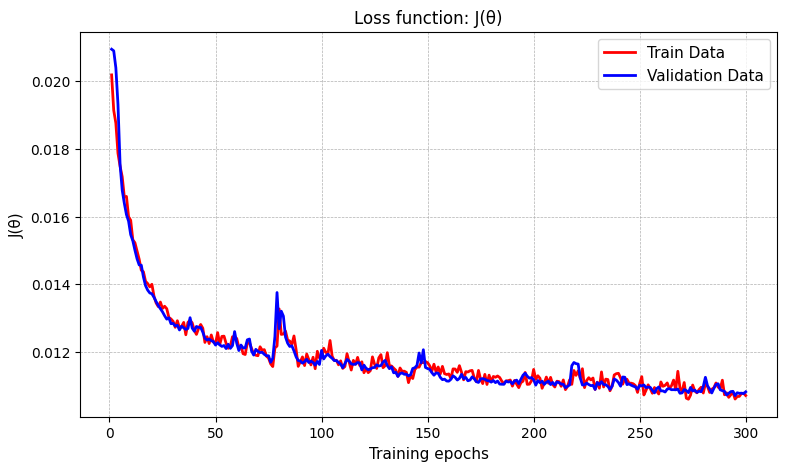

In [40]:
plt.figure(figsize = (9, 5))
plt.plot(np.arange(1, len(loss_values_train) + 1), np.array(loss_values_train), 'r-', linewidth = 2.0, label = 'Train Data')
plt.plot(np.arange(1, len(loss_values_val) + 1), np.array(loss_values_val), 'b-', linewidth = 2.0, label = 'Validation Data')
plt.title(r"Loss function: J(θ)")
plt.xlabel('Training epochs', fontsize = 11)
plt.ylabel('J(θ)', fontsize = 11)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(fontsize = 11)
plt.show()

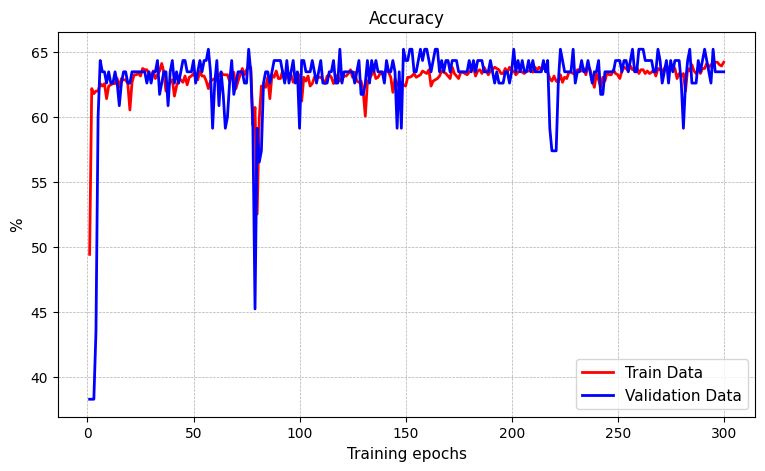

In [45]:
plt.figure(figsize = (9, 5))
plt.plot(np.arange(1, len(accuracy_train) + 1), np.array(accuracy_train), 'r-', linewidth = 2.0, label = 'Train Data')
plt.plot(np.arange(1, len(accuracy_val) + 1), np.array(accuracy_val), 'b-', linewidth = 2.0, label = 'Validation Data')
plt.title(r"Accuracy")
plt.xlabel('Training epochs', fontsize = 11)
plt.ylabel('%', fontsize = 11)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(fontsize = 11)
plt.show()

### __(2) Use custom dataloader for test dataset (return image tensor and file name)__

In [46]:
def my_data_loader_test(path, image_size = image_size, normilize = True, mean = [0.4190, 0.3147, 0.3084], std = [0.4238, 0.4043, 0.4237]):

    file_names = os.listdir(path)
    labels = torch.as_tensor([0] * len(file_names))
    path_list = [path + "/"] * len(file_names)
    file_paths = [p + f for (p, f) in zip(path_list, file_names)]


    if normilize:
        transform = transforms.Compose([
                transforms.PILToTensor(),
                transforms.Resize(image_size),
                transforms.ConvertImageDtype(torch.float),
                transforms.Normalize(mean = mean, std = std)
            ])
    else:
        transform = transforms.Compose([
                transforms.PILToTensor(),
                transforms.Resize(image_size),
                transforms.ConvertImageDtype(torch.float)
            ])

    # Load pictures
    dataset_X =  []

    for file_path in file_paths:

        img = transform(Image.open(file_path))
        dataset_X.append(img)

    dataset_X = torch.stack(dataset_X)


    return [list((dataset_X, labels))], file_names

In [47]:
# Define dataset directory and batch size
data_test = './data/test'

In [48]:
test_dataloader, test_file_names = my_data_loader_test(data_test, image_size = image_size, normilize = True, mean = train_mean, std = train_std)

In [49]:
# Check it's working
for i, (X, _) in enumerate(test_dataloader):
    # print(f"Batch: {batch+1}")
    print(f"X shape: {X.size()}")
    print(f"X[0].shape = {X[0].shape}")

X shape: torch.Size([380, 3, 256, 256])
X[0].shape = torch.Size([3, 256, 256])


### __Plot of random test samples (normilized)__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


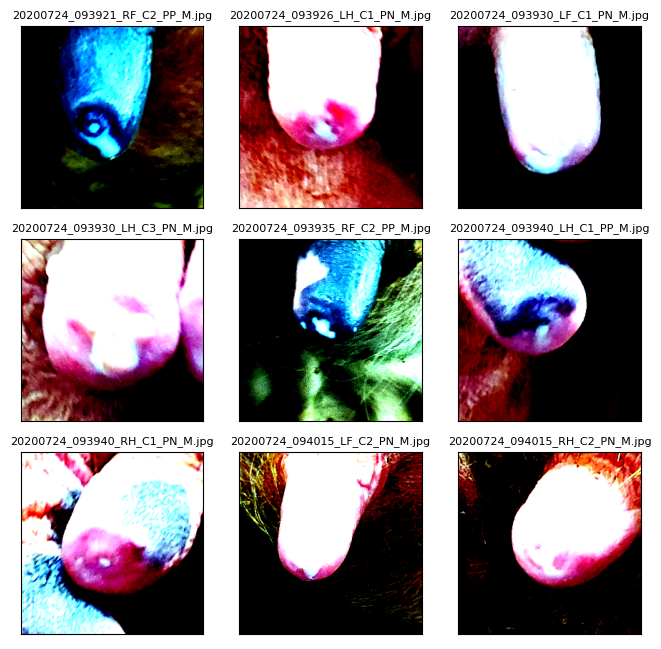

In [50]:
plt.figure(figsize = (8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_dataloader[0][0][i].permute(1, 2, 0))
    plt.title(f'{test_file_names[i]}', fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace = 0.2, hspace = 0.12)

### __Predict test data__

In [72]:
# Load a saved model 
# model = torch.jit.load('./saved_models/....pt').to(device)
# print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}\n")

In [66]:
# Predict part:
# In test phase, we don't need to compute gradients (for memory efficiency)
# Set the network to testing validation
model.eval()

# Iterate over the batches of testing data
with torch.no_grad():

    for i, (x_test, _) in enumerate(test_dataloader):

        x_test = x_test.to(device)

        # Forward pass
        output_test = model(x_test)
        predicted_test = output_test.argmax(dim = 1, keepdim = True)
        # predicted_test = output_test[0].argmax(dim = 1, keepdim = True) 


# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [67]:
# Convert from tensor to list
predicted = predicted_test.squeeze().tolist()
# predicted = [int(n) for n in predicted_test]

In [68]:
# The first twenty file names of the validation data
test_file_names[:10]

['20200724_093921_RF_C2_PP_M.jpg',
 '20200724_093926_LH_C1_PN_M.jpg',
 '20200724_093930_LF_C1_PN_M.jpg',
 '20200724_093930_LH_C3_PN_M.jpg',
 '20200724_093935_RF_C2_PP_M.jpg',
 '20200724_093940_LH_C1_PP_M.jpg',
 '20200724_093940_RH_C1_PN_M.jpg',
 '20200724_094015_LF_C2_PN_M.jpg',
 '20200724_094015_RH_C2_PN_M.jpg',
 '20200724_094108_LF_C1_PP_M.jpg']

In [69]:
# Create a csv folder
csv_folder = "./csv"

if not os.path.exists(csv_folder):
    os.makedirs(csv_folder)

In [70]:
# Make a timestamp
time_stamp = datetime.now().timestamp()
year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

In [71]:
# Save test data predictions to CSV files
df = pd.DataFrame(list(zip(test_file_names, predicted)))
df.to_csv('./csv/predicted_' + year_time + '.csv', index = False, header = False)

In [52]:
# Export (save) of the model:
save_model()

# 3. Evaluate your model using the developed software

<center>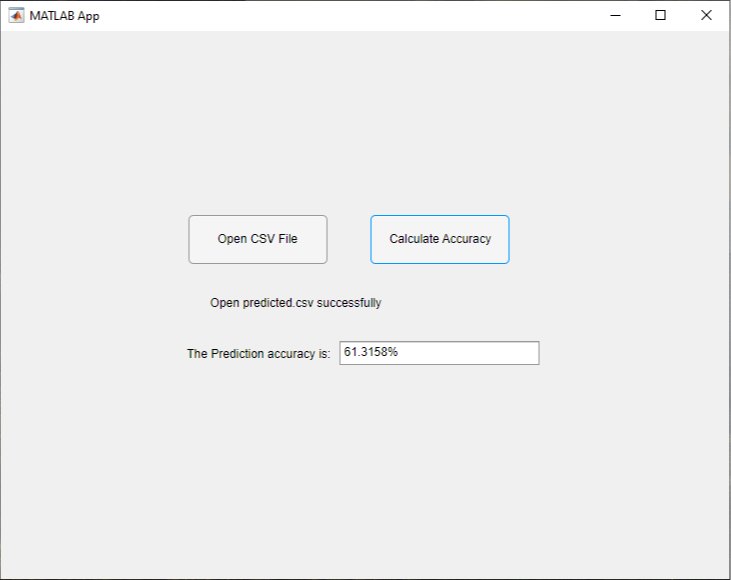</center>

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/369477781_Convolutional_Neural_Networks_for_Accurate_Cow_Teat_Image_Classification

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# References

- PyTorch Tutorial: Building a Simple Neural Network From Scratch : https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

- PyTorch: Training your first Convolutional Neural Network (CNN) : https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

- Tuning Adam Optimizer Parameters in PyTorch : https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html

- How to Create and Use a PyTorch DataLoader : https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

- Implementing Dropout in PyTorch: With Example : https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

- Split a python list into other "sublists" i.e smaller lists : https://stackoverflow.com/questions/9671224/split-a-python-list-into-other-sublists-i-e-smaller-lists

- Converting an image to a Torch Tensor in Python : https://www.geeksforgeeks.org/converting-an-image-to-a-torch-tensor-in-python/

- How to Normalize Image Dataset in PyTorch : https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html